# Part 1: Fully Connected Layers

Daniel-Alexandru Bejan (474404)
Patrick Schaper (534366)

The provided dataset contains possible combinations for the game Yathzee. If you don’t know the rules for this dice game, please have a look at: https://en.wikipedia.org/wiki/Yahtzee.

Please note: the dataset is imbalanced. This means that you might need to balance it first
before you will get good results! There a several possible solutions, please read: https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758 for a better understanding.

You will need to build a neural network that is able to predict the label for 5 thrown dice. The available labels are mentioned in the table below.

- 3-of-a-kind: Three dice the same.
- 4-of-a-kind: Four dice the same.
- Full-house: Three of one number and two of another
- small-straight Four sequential dice: (1-2-3-4, 2-3-4-5, or 3-4-5-6)
- Large-straight Five sequential dice: (1-2-3-4-5 or 2-3-4-5-6)
- Yathzee: All five dice the same
- Nothing: None of the above combinations has been thrown

**Goal of the assignment**

The overall goal is to experiment with deep learning and find out what gives you the
best results. Don’t forget to compare the results and write a conclusion!
Experiments we expect you to carry out:
- Playing around with different networks sizes
 - Different number of layers
 - Different number of neurons per layer
 - At least 6 different networks with a minimum of 1 hidden layer per network
- Comparison of different activation functions:
 - Sigmoid
 - Tanh
 - ReLu
- Difference with and without dropout.

The notebook should contain:
- For each neural network that you train: graphs from TensorBoard or Matplotlib showing the accuracy and the loss for train set and validation set and the accuracy scores for the test set.
- Your observations and conclusions per network (and graph)!
- An export of your best trained network and a way to run this exported model.

**Hints**

In order to build proper neural networks, keep in mind:
- Convert the labels into one-hot-encoded values.
- Use cross-entropy as loss function for classification.
- Create a proper output layer that uses SoftMax activation.
- Use the accuracy metric to measure your classification performance.
- Avoid overfitting by using dropout, a test set (which you use in the end) and cross validation.

Export your best model and add a cell to your notebook that loads the model and is
able to validate your model, by loading in a dataset from file and feeding it into the
network. This cell should show the accuracy of the classifier.


## Analyse the Data

In [1]:
import pandas as pd

df = pd.read_csv('MLBD-dataset-yahtzee.csv')
df.head() 

,dice1,dice2,dice3,dice4,dice5,label
0,3,6,6,2,5,nothing
1,3,6,1,3,4,nothing
2,2,2,5,5,3,nothing
3,1,3,6,6,1,nothing
4,1,4,6,3,5,small-straight


In [2]:
df.shape

(5832, 6)

In [3]:
df.notnull().sum()

dice1    5832
dice2    5832
dice3    5832
dice4    5832
dice5    5832
label    5832
dtype: int64

In [4]:
df.groupby(['label'])['label'].count()

label
four-of-a-kind      116
full-house          221
large-straight      178
nothing            3868
small-straight      549
three-of-a-kind     896
yathzee               4
Name: label, dtype: int64

### First result of analysing

We see a very unbalanced data set. One rubric stands out particularly strongly. The number of "yathzee's" is just 4. According to the rules of the game, a "yathzee" occurs when all dice show the same number. Thus, the minimum number of "yathzee's" is six. Thus, one could normally add the missing records and have a perfect model regarding the yathzee's. This could also be done for the other classes and would create a completely perfect model. But this is probably not our task, so we only mention this here to show that we are aware of it.

For the further process we will not create any datasets manually. We only work with the over and undersampling functions.

In [5]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

df.label = pd.factorize(df.label)[0]

features = []
for feature in df.columns:
    if feature != 'label':
        features.append(feature)
X = df[features]
y = df['label']

#y_encoded = LabelEncoder().fit_transform(y)

#counter = Counter(y_encoded)
#for k,v in counter.items():
# per = v / len(y) * 100
# print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
#plt.bar(counter.keys(), counter.values())
#plt.show()

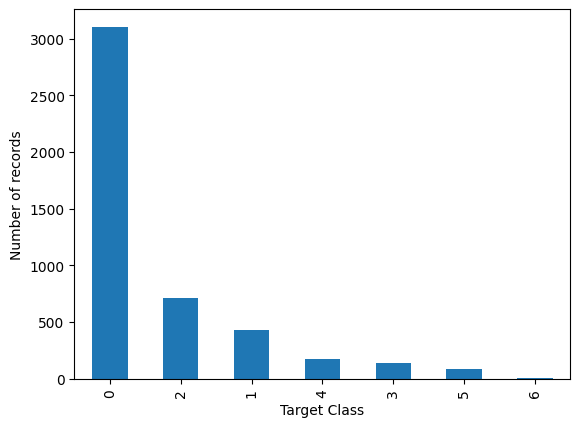

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

count = y_train.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

y_test.shape (1167,) len 1167 type <class 'pandas.core.series.Series'>
y_score.shape (1167, 7) len 1167 type <class 'numpy.ndarray'>


ValueError: Found input variables with inconsistent numbers of samples: [7002, 8169]

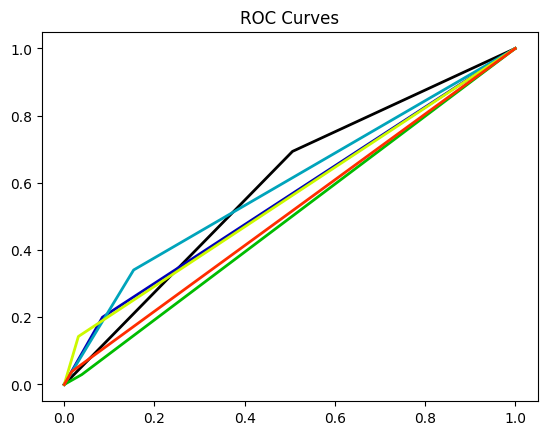

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from sklearn import metrics

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_score = model.predict_proba(X_test)
y_pred = model.predict(X_test)

# print(y_test)
# print(type(y_test))
print("y_test.shape", y_test.shape, "len", len(y_test), "type", type(y_test))
# print(y_score)
print("y_score.shape", y_score.shape, "len", len(y_score), "type", type(y_score))

# Plot metrics 
plot_roc(y_test, y_score)
plt.show()

plot_precision_recall(y_test, y_score)
plt.show()